# QGraphs Data - Creation of digraphs

*This notebook explores creation* ***QGgraphs (Quantum Digraphs)*** *in* ***Networkx**.*

**By:** Jacob Cybulski<br>
**Date:** August 2024<br>
**Aims:** The goal of this notebook is to create random *Quantum Digraphs (QGraphs)*.<br/>
**Networkx technical refs:**
- Web site: https://networkx.org/documentation/stable/index.html
- Tutorial: https://networkx.org/documentation/stable/tutorial.html

## What are QGraphs

A *QGraph* is a weighted directed graph, which excludes parallel edges (in the same direction), but allowing loops. It defines a stochastic navigation between its verteces, where the probability of taking a particular edge from a given vertex is given by the edge weight.

Formally, a qgraph $G$ is defined as a weighted digraph:

$$G = \{V, E, w\},$$

where $V = \{v\}$ is a set of digraph vertices, $E = \{(v_s,v_t) : v_s, v_t \in V\}$ is a set of directional edges, and $|V|$ being the number of vertices in $V$.<br/>
Function $w(V, V)\rightarrow R$ assigns weights to all edges, such that:

$$w(v_s, v_t) =
\left\{
	\begin{array}{ll}
		p(v_t | v_s)  & \forall_{v_s, v_t \in V,\;(v_s, v_t) \in E}\\
		0 & \forall_{v_s, v_t \in V,\;(v_s, v_t) \notin E}
	\end{array}
\right.
$$

where $p(v_t | v_s)$ is the probability of navigating over the edge $(v_s, v_t)$ when arrived at the source vertex $v_s$ to its target $v_t$ (including the self), and:

$$\forall_{(v_s, v_t) \in E}\: \sum_{v_t} w(v_s, v_t) = 1.$$

This means that every digraph vertex must have at least one outgoing link.

An arbitrary weighted digraph $G = \{V, E, w(V, V)\}$ can be expanded to become a QGraph $G^{'} = \{V^{'}, E^{'}, w^{'}(V^{'}, V^{'})\}$ by adding loops to all verteces $v$ with outdegree 0, and rescaling weights to add up to 1. Now:

$$\forall_{v \in V}\; v \in V^{'} \land \forall_{e \in E}\; e \in E^{'}$$
$$\forall_{v_s \in V}\;(\forall_{v_t \in V}\;(v_s, v_t) \notin E) \Longrightarrow (v_s, v_s) \in E^{'} \land w^{'}(v_s, v_s) = 1$$
$$\forall_{(v_s, v_t) \in E}\; w^{'}(v_s, v_t) = \frac{w(v_s, v_t)}{\sum_{(v_s, v_i) \in E}\; w(v_s, v_i)}$$

In [1]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/pl-cuda12/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages',
 '.',
 '..']

In [2]:
### General libraries

import matplotlib.pyplot as plt
import matplotlib.patches as pltpat
import pylab
import math
from IPython.display import clear_output

from matplotlib import set_loglevel
set_loglevel("error")

%matplotlib inline

In [3]:
### Get utilities
from utils.Digraphs import * 

## Networkx digraph manipulation

### Digraph generation

In [4]:
from pylab import *
import json
import networkx as nx
from networkx.readwrite import json_graph

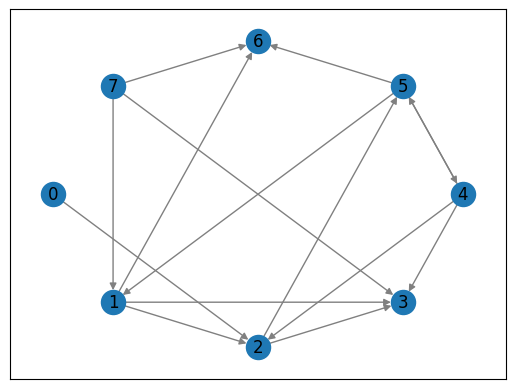

In [5]:
### Create a random graph
node_no = 8
edge_p = 0.25
g = nx.gnp_random_graph(node_no, edge_p, directed=True)
draw_digraph(g)

### Testing digraph saving and loading

In [6]:
### Saving of a graph to a file
vers = 0
g_path = f'sample_graphs/digraph_{node_no}_{edge_p}_v{vers}.json'
save_digraph(g, g_path)
print(f'Saved graph in file: {g_path}')

Saved graph in file: sample_graphs/digraph_8_0.25_v0.json


Loaded graph from file: sample_graphs/digraph_8_0.25_v5.json


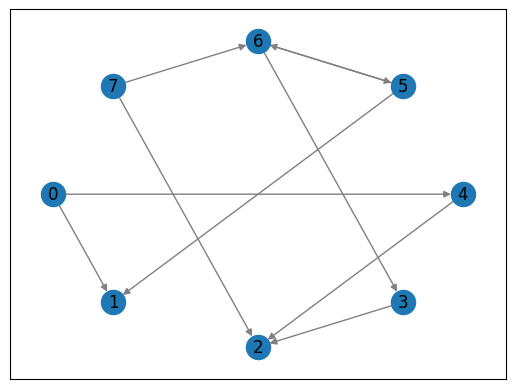

In [7]:
### Loading a graph from a file
g_path = 'sample_graphs/digraph_8_0.25_v5.json'
g_sel = load_digraph(g_path)
draw_digraph(g_sel)
print(f'Loaded graph from file: {g_path}')

In [8]:
nx.node_link_data(g_sel)

{'directed': True,
 'multigraph': False,
 'graph': {},
 'nodes': [{'id': 0},
  {'id': 1},
  {'id': 2},
  {'id': 3},
  {'id': 4},
  {'id': 5},
  {'id': 6},
  {'id': 7}],
 'links': [{'source': 0, 'target': 1},
  {'source': 0, 'target': 4},
  {'source': 3, 'target': 2},
  {'source': 4, 'target': 2},
  {'source': 5, 'target': 1},
  {'source': 5, 'target': 6},
  {'source': 6, 'target': 3},
  {'source': 6, 'target': 5},
  {'source': 7, 'target': 2},
  {'source': 7, 'target': 6}]}

### Generate a QGraph for modeling

***Creation of a quantum digraph includes three stages:***<br/>
- *Converting an undirected graph to an adjacency matrix*
- *Changing all undirected edges to weighted directed edges*
- *Expanding a digraph to a QGraph (quantum digraph) by adding loops to stop vertices*

Note that on measurement, probabilities of navigation from a vertex to all possible targets adds to 1.

In [9]:
### Convert an adjacency of a unweighted graph to adjacency of a weighted graph
#   Two methods of generating weights:
#   - rand: random weights are generated
#   - scale: existing weights are scaled
def digraph_adj_weigh(unw_adj, method='rand'):
    w_adj = unw_adj.copy().astype(float)
    for r in range(unw_adj.shape[0]):
        r_sum = sum(unw_adj[r])
        r_nz = np.count_nonzero(unw_adj[r])
        if r_sum != 0.0:
            # Edges available - generate weights
            if method == 'rand':
                nz_weights = np.random.random(r_nz)
            else:
                nz_weights = np.array([num*1.0 for num in unw_adj[r] if num])
            nz_weights /= nz_weights.sum()
            w_no = 0
            for c in range(unw_adj.shape[1]):
                if unw_adj[r, c] > 0:
                    w_adj[r, c] = nz_weights[w_no]
                    w_no += 1
    return w_adj

### Expand a weighted digraph to eliminate vertices with out-dgree=0
def digraph_adj_expand(w_adj):
    exp_adj = w_adj.copy() #.toarray()
    for r in range(w_adj.shape[0]):
        r_sum = np.count_nonzero(w_adj[r])
        if r_sum == 0:
            # No outgoing links - create a loop
            exp_adj[r, r] = 1.0
    return exp_adj

### Prepare a quantum digraph for quantum modeling
#   Convert an undirected graph into QGraph
def digraph_expanded_and_weighed(g, method='rand'):
    g_adj = nx.adjacency_matrix(g).todense()
    g_adj_expanded = digraph_adj_expand(g_adj)
    g_adj_weighed = digraph_adj_weigh(g_adj_expanded, method=method)
    g_new = nx.DiGraph(g_adj_weighed)
    return g_new

### Testing generation of QGraphs

In [10]:
### We are going to use the previously loaded digraph g_sel
g_sel_node_no = g_sel.number_of_nodes()
g_sel_edge_no = g_sel.number_of_edges()
print(f'Digraph of {g_sel_node_no} nodes and {g_sel_edge_no} edges')

Digraph of 8 nodes and 10 edges


#### First let us do this step by step and observe results

In [11]:
### Convert a graph to an adjacency matrix
import scipy as sci # Not used as yet
adj_sel = nx.adjacency_matrix(g_sel).todense()# adj_sel.toarray()
adj_sel

array([[0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0]])

In [12]:
### Expand the digraph to eliminate stop vertices (out-degree=0)
adj_exp = digraph_adj_expand(adj_sel)
np.around(adj_exp, 3)

array([[0, 1, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0]])

In [13]:
### Generate edge probability weights (adding to 1.0)
adj_w = digraph_adj_weigh(adj_exp, method='scale') # rand scale
np.around(adj_w, 3)

array([[0. , 0.5, 0. , 0. , 0.5, 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0. , 0. , 0. , 0.5, 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. ],
       [0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0. ]])

#### Now let us generate a QGraph in a single step

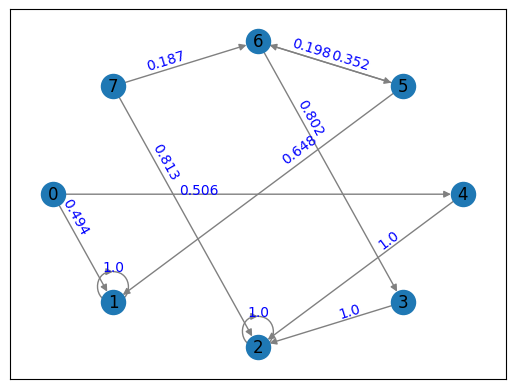

In [14]:
### Test graph generation in one step
g_new = digraph_expanded_and_weighed(g_sel, method='rand') # scale or rand
# nx.draw(g_new, with_labels = True)
draw_weighted_digraph(g_new, 'weight', ax=None)

In [15]:
vers = 6
g_path = f'sample_graphs/digraph_{node_no}_{edge_p}_v{vers}.json'
save_digraph(g_new, g_path)
print(f'Saved graph in file: {g_path}')

Saved graph in file: sample_graphs/digraph_8_0.25_v6.json


In [16]:
nx.node_link_data(g_new)

{'directed': True,
 'multigraph': False,
 'graph': {},
 'nodes': [{'id': 0},
  {'id': 1},
  {'id': 2},
  {'id': 3},
  {'id': 4},
  {'id': 5},
  {'id': 6},
  {'id': 7}],
 'links': [{'weight': 0.4944293585610806, 'source': 0, 'target': 1},
  {'weight': 0.5055706414389194, 'source': 0, 'target': 4},
  {'weight': 1.0, 'source': 1, 'target': 1},
  {'weight': 1.0, 'source': 2, 'target': 2},
  {'weight': 1.0, 'source': 3, 'target': 2},
  {'weight': 1.0, 'source': 4, 'target': 2},
  {'weight': 0.6475441003604834, 'source': 5, 'target': 1},
  {'weight': 0.3524558996395167, 'source': 5, 'target': 6},
  {'weight': 0.8015920962589961, 'source': 6, 'target': 3},
  {'weight': 0.1984079037410039, 'source': 6, 'target': 5},
  {'weight': 0.8129708714007062, 'source': 7, 'target': 2},
  {'weight': 0.18702912859929377, 'source': 7, 'target': 6}]}

## System

In [17]:
!pip list | grep -e torch -e PennyLane -e networkx

networkx                  3.3
PennyLane                 0.36.0
PennyLane_Lightning       0.36.0
PennyLane_Lightning_GPU   0.36.0
PennyLane-Rigetti         0.36.0
torch                     2.3.1+cu121
torchaudio                2.3.1+cu121
torchsummary              1.5.1
torchvision               0.18.1+cu121
